<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/NLP-Projects/blob/main/SpaCy-Pipeline-Analyzer/SpaCy_Pipelines_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Framwords and Basic Setup

In [1]:
"""
SpaCy Pipeline Exploration Project

This script demonstrates the SpaCy pipeline by processing a small text corpus,
displaying default attributes (pos_, lemma_, dep_), and adding a custom component
to identify words starting with a specific letter (e.g., 'c'). Results are
presented in a tabular format and visualized.
"""

import spacy
import pandas as pd
from spacy.tokens import Token
from spacy.language import Language
import logging
from typing import List, Dict, Optional
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Setup warning level
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Pipeline Analyzer

In [5]:
class SpacyPipelineAnalyzer:
    """A class to analyze text using SpaCy's pipeline and custom components."""

    def __init__(self, model_name: str = "en_core_web_sm"):
        """
        Initialize with a SpaCy model.

        Args:
            model_name (str): Name of the SpaCy model to load (default: 'en_core_web_sm').
        """
        try:
            self.nlp = spacy.load(model_name)
            logger.info(f"SpaCy model '{model_name}' loaded successfully")
        except OSError as e:
            logger.error(f"Model '{model_name}' not found. Please download it using 'python -m spacy download {model_name}'")
            raise e

        # Register custom token extension
        Token.set_extension("starts_with_c", default=False, force=True)
        self.results = {}

    def add_custom_component(self) -> None:
        """Add a custom component to identify words starting with 'c'."""

        @Language.component("starts_with_c_component")
        def starts_with_c_component(doc):
            for token in doc:
                token._.starts_with_c = token.text.lower().startswith("c")
            return doc

        try:
            self.nlp.add_pipe("starts_with_c_component", last=True)
            logger.info("Custom component 'starts_with_c_component' added to pipeline")
        except ValueError as e:
            logger.warning(f"Component already exists or error occurred: {e}")

    def process_text(self, text: str) -> Dict[str, pd.DataFrame]:
        """
        Process text with the pipeline and collect attributes.

        Args:
            text (str): Input text to process.

        Returns:
            Dict[str, pd.DataFrame]: Results with standard and custom attributes.
        """
        try:
            # Process with default pipeline (before adding custom component)
            doc_default = self.nlp(text, disable=["starts_with_c_component"] if "starts_with_c_component" in self.nlp.pipe_names else [])
            data_default = [
                {
                    "Text": token.text,
                    "POS": token.pos_,
                    "Lemma": token.lemma_,
                    "Dependency": token.dep_
                }
                for token in doc_default
            ]
            self.results["default"] = pd.DataFrame(data_default)

            # Process with full pipeline (including custom component)
            doc_custom = self.nlp(text)
            data_custom = [
                {
                    "Text": token.text,
                    "POS": token.pos_,
                    "Lemma": token.lemma_,
                    "Dependency": token.dep_,
                    "Starts with 'c'": token._.starts_with_c
                }
                for token in doc_custom
            ]
            self.results["custom"] = pd.DataFrame(data_custom)

            logger.info("Text processed successfully with default and custom pipelines")
            return self.results
        except Exception as e:
            logger.error(f"Error processing text: {e}")
            return {}

    def display_results(self) -> None:
        """Display results in a formatted table."""
        for key, df in self.results.items():
            if df.empty:
                logger.warning(f"No data for {key} pipeline")
                continue
            print(f"\n{key.replace('_', ' ').title()} Pipeline Results:")
            print(df.to_string(index=False))
            logger.info(f"Displayed results for {key} pipeline")

    def visualize_attribute_distribution(self) -> None:
        """Visualize the distribution of POS tags and custom attribute."""
        if not self.results:
            logger.warning("No results to visualize")
            return

        # Prepare data for visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # POS distribution (default pipeline)
        if "default" in self.results:
            pos_counts = self.results["default"]["POS"].value_counts()
            sns.barplot(x=pos_counts.index, y=pos_counts.values, ax=axes[0], palette="viridis")
            axes[0].set_title("POS Tag Distribution", fontsize=14, fontweight="bold")
            axes[0].set_xlabel("POS Tags")
            axes[0].set_ylabel("Count")
            axes[0].tick_params(axis="x", rotation=45)

        # Custom attribute distribution (custom pipeline)
        if "custom" in self.results:
            c_counts = self.results["custom"]["Starts with 'c'"].value_counts()
            sns.barplot(x=c_counts.index, y=c_counts.values, ax=axes[1], palette="magma")
            axes[1].set_title("Words Starting with 'c' Distribution", fontsize=14, fontweight="bold")
            axes[1].set_xlabel("Starts with 'c'")
            axes[1].set_ylabel("Count")

        plt.tight_layout()
        plt.savefig("pipeline_distribution.png")
        plt.show()
        logger.info("Attribute distribution visualized")

    def save_results(self, filepath: str = "spacy_pipeline_results.csv") -> None:
        """Save results to a CSV file."""
        if not self.results:
            logger.warning("No results to save")
            return

        combined_df = pd.concat([df.assign(Pipeline=key) for key, df in self.results.items()], ignore_index=True)
        combined_df.to_csv(filepath, index=False)
        logger.info(f"Results saved to {filepath}")



Default Pipeline Results:
    Text   POS   Lemma Dependency
     The   DET     the        det
     cat  NOUN     cat      nsubj
  sleeps  VERB   sleep       ROOT
 quietly   ADV quietly     advmod
      in   ADP      in       prep
     the   DET     the        det
    room  NOUN    room       pobj
       . PUNCT       .      punct
    Dogs  NOUN     dog   compound
   chase  NOUN   chase   compound
    cats  NOUN     cat       ROOT
      in   ADP      in       prep
     the   DET     the        det
    park  NOUN    park       pobj
   daily   ADV   daily     advmod
       . PUNCT       .      punct
       I  PRON       I      nsubj
    love  VERB    love       ROOT
  coding  VERB    code      xcomp
     and CCONJ     and         cc
creating  VERB  create       conj
     new   ADJ     new       amod
   tools  NOUN    tool       dobj
       . PUNCT       .      punct

Custom Pipeline Results:
    Text   POS   Lemma Dependency  Starts with 'c'
     The   DET     the        det            F

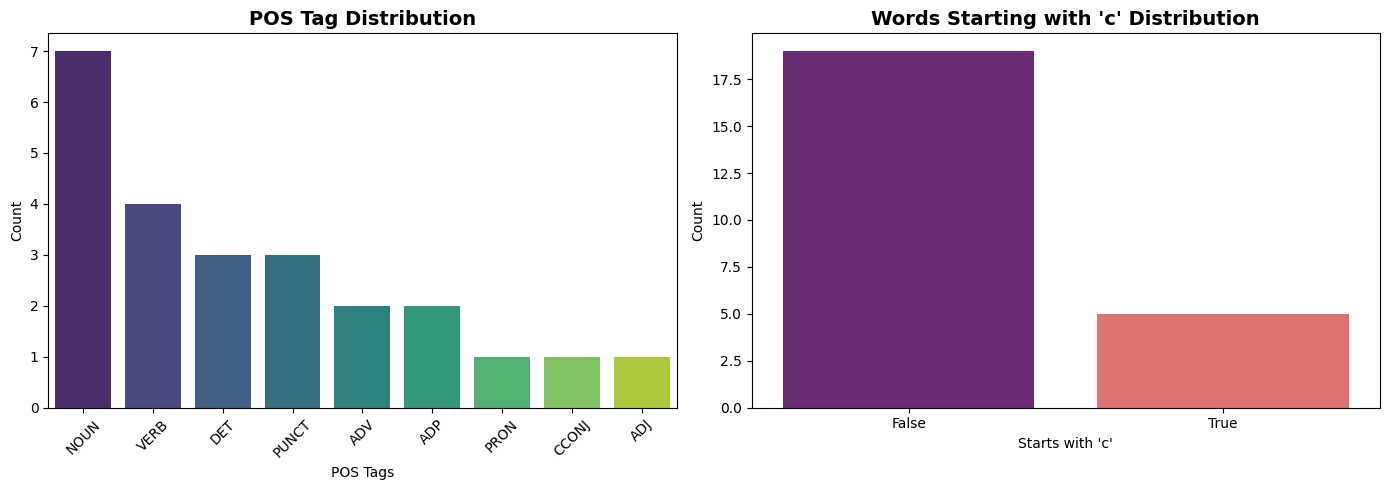

In [6]:
def main():
    """Main function to execute the SpaCy pipeline exploration project."""
    # Create a small text corpus (3 sentences)
    text = (
        "The cat sleeps quietly in the room. "
        "Dogs chase cats in the park daily. "
        "I love coding and creating new tools."
    )
    logger.info(f"Text corpus created: {text[:50]}...")

    # Initialize SpacyPipelineAnalyzer
    analyzer = SpacyPipelineAnalyzer()

    # Add custom component
    analyzer.add_custom_component()
    logger.info(f"Updated pipeline: {analyzer.nlp.pipe_names}")

    # Process text and collect attributes
    analyzer.process_text(text)

    # Display results
    analyzer.display_results()

    # Visualize attribute distribution
    analyzer.visualize_attribute_distribution()

    # Save results
    analyzer.save_results("spacy_pipeline_results.csv")


main()